In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf
import tensorflow_probability as tfp
from tqdm import tqdm_notebook as tqdm

from mbptycho.code.simulation import reloadSimulation
from skimage.feature import register_translation
from scipy import io
from mbptycho.code.recons.recons import PhaseOnlyReconstruction
import copy
import os

base_path = os.environ['HOME']

gpu = tf.config.experimental.list_physical_devices('GPU')[0]
tf.config.experimental.set_memory_growth(gpu, True)


cmap = copy.copy(mpl.cm.get_cmap('coolwarm'))
cmap.set_bad('black')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
strain_type = 'point_inclusion'
data_path =  f'{base_path}/code/mbptycho/experiments/python/{strain_type}_sparse/weak_peaks/'
sim_data_path = f'{data_path}/sim_{strain_type}.pkl'
sample_data_path = f'{data_path}/sample_{strain_type}.pkl'

save_plots = False

In [4]:
sm = reloadSimulation(sim_data_path, reload_sim=True)#sim_params={"HKL_list":[[1, 2, 0]]}
sm.sample.Ux_trunc.shape, sm.sample.params.sample_pix_size

File exists. Reloading...


((200, 200, 20), 0.005841818181818182)

## Reconstructing the phases/ separate magnitudes

In [70]:
recons = PhaseOnlyReconstruction(simulation=sm, shared_magnitudes=False)
                                 #phases_init=phases_init, magnitudes_init=magnitudes_init)

Setting background_level to 1e-08...


In [71]:
phases_lr = 1e-2
magnitude_lr = 1e-1
if not 'phases_v' in recons.optimizers:
    recons.setPhaseAdamOptimizer(phases_lr)
else:
    recons.optimizers['phases_v']['learning_rate'].assign(phases_lr)

if not 'magnitudes_log_v' in recons.optimizers:
    recons.setMagnitudeLogAdamOptimizer(magnitude_lr)
else:
    recons.optimizers['magnitudes_log_v']['learning_rate'].assign(magnitude_lr)

#recons.optimizers

In [ ]:
recons.minimize(500)

          epoch  train_loss   err_rho0   err_rho1   err_rho2   err_rho3  err_rho_film0  err_rho_film1  err_rho_film2  err_rho_film3
3006        501    1.13e+04      0.998      0.932       0.92      0.985           0.98          0.286           0.43          0.466
3012        502   1.03e+04      0.998      0.932      0.923      0.984       0.98      0.286      0.428      0.469
3018        503   1.09e+04      0.998      0.932      0.922      0.982      0.979      0.286      0.428       0.47
3024        504   1.12e+04      0.998      0.934      0.921      0.986       0.98      0.288      0.429      0.467
3030        505   1.13e+04      0.998      0.934      0.921      0.984      0.978      0.286      0.429      0.465
3036        506   1.12e+04      0.998       0.94      0.919       0.98      0.981      0.286      0.427      0.466
3042        507    1.2e+04      0.998       0.93      0.927      0.981      0.978      0.286      0.428      0.467
3048        508   1.29e+04      0.998      0.9

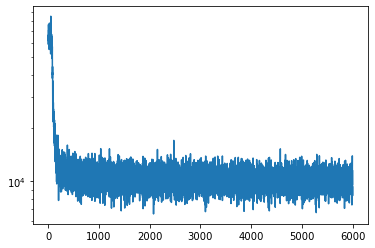

In [83]:
plt.plot(recons.datalog.dataframe.train_loss.dropna())
plt.yscale('log')

In [85]:

true_items = {}
recons_items = {}

if recons._model_type != 'phase':
    recons_items[r"$\alpha_x$"] = recons.ux_2d - recons.ux_2d.mean() 
    true_items[r"$\alpha_x$"] = recons._ux_true - recons._ux_true.mean() 

    recons_items[r"$\alpha_y$"] = recons.uy_2d - recons.uy_2d.mean()
    true_items[r"$\alpha_y$"] = recons._uy_true - recons._uy_true.mean()


if not recons._model_type == 'displacement_to_phase':

    for i in range(recons.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = rf"$\phi$({phase_label})"
        
        rollr, errr, phaser = register_translation( recons._rho_true[i], recons.rho_2d[i], upsample_factor=10)
        recons_items[labelstr] = np.angle(recons.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons._rho_true[i])

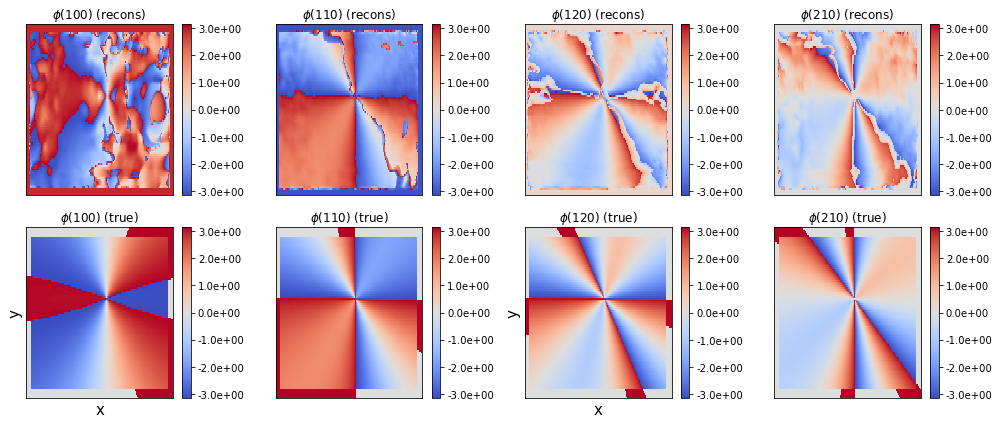

In [86]:
save_plots = False
if recons._model_type == 'phase':
    subplots_x = recons.rho_2d.shape[0] 
    figsize_x = subplots_x * 3.5
elif recons._model_type == 'displacement_to_phase':
    figsize_x = 8
    subplots_x = 2
else:
    subplots_x = (recons.rho_2d.shape[0] + 2) 
    figsize_x = subplots_x * 3.5

recons_suffix = recons._model_type

    
fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 
for i, (key, value) in enumerate(recons_items.items()):
    if i == 0 and recons._model_type != 'phase':
        vmin=-2.1
        vmax = 2.1
    elif i == 1 and recons._model_type!= 'phase':
        vmin = -0.21
        vmax = 0.21
    else:
        vmin = -np.pi
        vmax = np.pi
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(value, cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

if not recons._model_type=='displacement_to_phase':
    axs[1,2].set_xlabel('x', fontsize=15)
    axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()

if save_plots:
    
    plt.savefig(f'{data_path}_recons_{recons_suffix}.png', bbox_inches='tight')
plt.show()

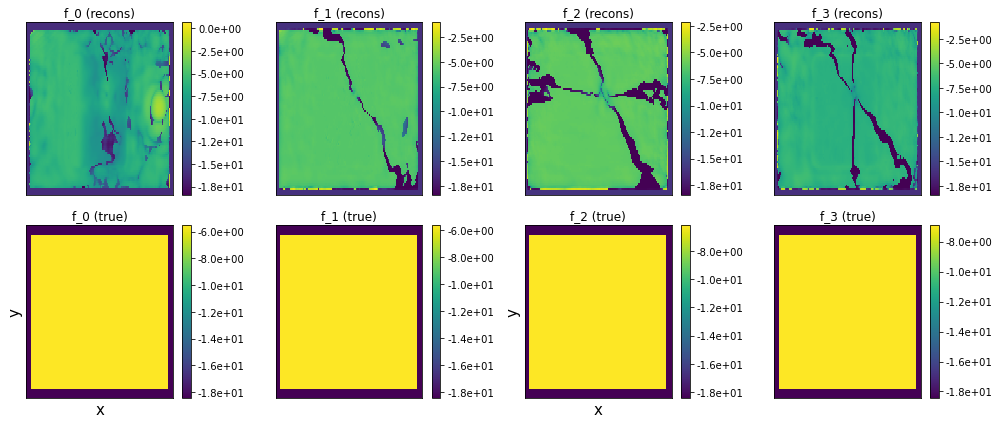

In [87]:
subplots_x = recons.rho_2d.shape[0] 
figsize_x = subplots_x * 3.5

fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 

for i in range(recons.rho_2d.shape[0]):
    recons_amplitudes = 1e-8 + np.abs(recons.rho_2d[i])#[10:-10,10:-10])
    true_amplitudes = 1e-8 + np.abs(recons._rho_true[i])#[10:-10,10:-10])
    
    cp0 = axs[0, i].pcolormesh(np.log(recons_amplitudes))
    axs[0, i].set_title(f"f_{i} (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%.1e")
    
    cp1 = axs[1, i].pcolormesh(np.log(true_amplitudes))
    axs[1, i].set_title(f"f_{i} (true)")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    plt.colorbar(cp1, ax=axs[1, i], format="%.1e")
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

axs[1,2].set_xlabel('x', fontsize=15)
axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()
if save_plots:
    plt.savefig(f'{data_path}_recons_amplitudes.png', bbox_inches='tight')
plt.show()


In [88]:
recons.saveOutputsAndLog(data_path)

rhos saved in /raid/home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/weak_peaks//rho_phase_sep_mags.npz
dataframe saved in /raid/home/skandel/code/mbptycho/experiments/python/point_inclusion_sparse/weak_peaks//df_phase_sep_mags.gz


In [89]:
phases_init = np.angle(recons.rho_2d)
magnitudes_init = np.abs(recons.rho_2d)

## Convert phases to displacements

In [90]:
from mbptycho.code.recons.recons import DisplacementFromPhaseReconstruction

In [91]:
recons2 = DisplacementFromPhaseReconstruction(simulation=sm, phases_init=phases_init)

In [92]:
recons2.minimize()

       epoch     err_ux     err_uy  err_ux_film  err_uy_film
1          1      0.702      0.987        0.646         0.97


In [93]:

true_items = {}
recons2_items = {}

if recons2._model_type != 'phase':
    recons2_items[r"$\alpha_x$"] = recons2.ux_2d - recons2.ux_2d.mean() 
    true_items[r"$\alpha_x$"] = recons2._ux_true - recons2._ux_true.mean() 

    recons2_items[r"$\alpha_y$"] = recons2.uy_2d - recons2.uy_2d.mean()
    true_items[r"$\alpha_y$"] = recons2._uy_true - recons2._uy_true.mean()


if not recons2._model_type == 'displacement_to_phase':

    for i in range(recons2.rho_2d.shape[0]):
        phase_label = ''.join(sm.params.HKL_list[i].astype('str'))
        labelstr = rf"$\phi$({phase_label})"
        
        rollr, errr, phaser = register_translation( recons2._rho_true[i], recons2.rho_2d[i], upsample_factor=10)
        recons2_items[labelstr] = np.angle(recons2.rho_2d[i] * np.exp(1j * phaser))
        true_items[labelstr] = np.angle(recons2._rho_true[i])

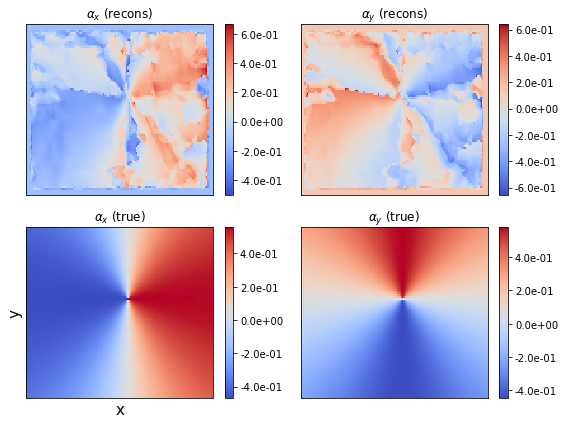

In [94]:
save_plots = False
if recons2._model_type == 'phase':
    subplots_x = recons2.rho_2d.shape[0] 
    figsize_x = subplots_x * 3.5
elif recons2._model_type == 'displacement_to_phase':
    figsize_x = 8
    subplots_x = 2
else:
    subplots_x = (recons2.rho_2d.shape[0] + 2) 
    figsize_x = subplots_x * 3.5

recons2_suffix = recons2._model_type

    
fig, axs = plt.subplots(2, subplots_x, figsize=[figsize_x, 6]) 
for i, (key, value) in enumerate(recons2_items.items()):
    if i == 0 and recons2._model_type != 'phase':
        vmin=-2.1
        vmax = 2.1
    elif i == 1 and recons2._model_type!= 'phase':
        vmin = -0.21
        vmax = 0.21
    else:
        vmin = -np.pi
        vmax = np.pi
    
    #value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp0 = axs[0, i].pcolormesh(value, cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[0, i].set_title(key + " (recons)")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    plt.colorbar(cp0, ax=axs[0, i], format="%2.1e")
    
    true_value = true_items[key] 
    #true_value[~(sm.sample.amplitudes_trunc_mask[pady0: pady0 + nyvar, padx0: padx0 + nxvar, nzvar//2])] = np.nan
    cp1 = axs[1, i].pcolormesh(true_items[key], cmap='coolwarm')#, vmin=vmin, vmax=vmax)
    axs[1, i].set_title(key + " (true)")
    plt.colorbar(cp1, ax=axs[1, i], format="%2.1e")
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    
axs[1,0].set_xlabel('x', fontsize=15)
axs[1,0].set_ylabel('y', fontsize=15)

if not recons2._model_type=='displacement_to_phase':
    axs[1,2].set_xlabel('x', fontsize=15)
    axs[1,2].set_ylabel('y', fontsize=15)


plt.tight_layout()

if save_plots:
    
    plt.savefig(f'{data_path}_recons_{recons_suffix}.png', bbox_inches='tight')
plt.show()

In [100]:
recons2.saveOutputsAndLog(data_path)

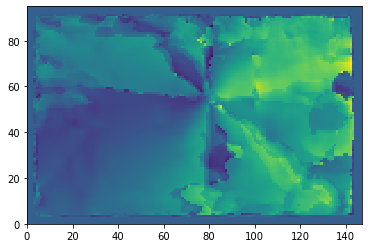

In [102]:
plt.pcolormesh(recons2.ux_2d)

In [96]:

import matplotlib.colors as colors

In [97]:
ux = recons2_items[r'$\alpha_x$']
uy = recons2_items[r'$\alpha_y$']

In [98]:
dux = np.gradient(ux)#, sm.sample.params.sample_pix_size)
duy = np.gradient(uy)#, sm.sample.params.sample_pix_size)
du = np.stack([dux, duy], axis=0)

<ipython-input-99-0a9d9b3db263>:11: MatplotlibDeprecationWarning: default base will change from np.e to 10 in 3.4.  To suppress this warning specify the base keyword argument.
  im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,


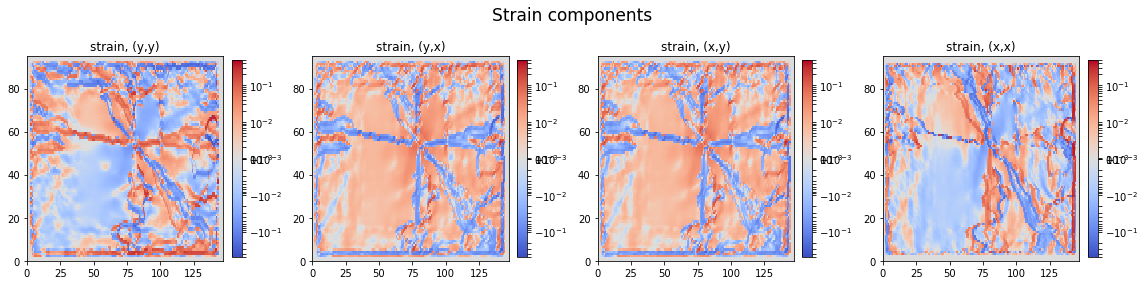

In [99]:
s = np.zeros(du.shape)
fig, axs = plt.subplots(1,4, figsize=(16,4))
coord_axes = {0:'y', 1:'x', 2:'z'}
for i in range(2):
    for j in range(2):
        s[i,j] = 0.5 * (du[j,i] + du[i,j]) #* sm.sample.params.lattice[0]
        # s[i,j][plots_3d_mask_trunc] = np.nan
        #s[i,j][~sm.sample.amplitudes_trunc_mask] = np.nan
        sl = s[i,j, :, :]
        sl = sl#[10:-10,10:-10]
        im = axs[i * 2 + j].pcolormesh(sl, cmap=cmap,   norm=colors.SymLogNorm(linthresh=0.001, linscale=0.001,
                                              vmin=-.5, vmax=0.5))
        axs[i * 2 + j].set_title(f'strain, ({coord_axes[i]},{coord_axes[j]})')
        plt.colorbar(im, ax=axs[2*i + j], fraction=0.046, pad=0.04)
plt.suptitle('Strain components', fontsize=17)
plt.tight_layout()

#if save_plots:
    #plt.savefig(f'{data_path}strain.pdf', bbox_inches='tight')
          
plt.show()  